In [1]:
#устанавливаем и импортируем все необходимое
!pip install rouge evaluate -q

import evaluate

import gc
import glob

import json

import kagglehub

import math
import multiprocessing as mp

import numpy as np

import os

import pandas as pd

import re
from rouge import Rouge

from sklearn.model_selection import train_test_split
import string
import sentencepiece as spm

import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00


# Загружаем путь к датасету

In [5]:
path = kagglehub.dataset_download("varunucl/wikihow-summarization")

print("Path to dataset files:", path)

100%|██████████| 200M/200M [00:00<00:00, 216MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/varunucl/wikihow-summarization/versions/1


# Чистка токенизация, чанки

In [6]:
#загружаем датасет в датафрейм
INPUT_CSV = path + "/wikihowAll.csv"
df = pd.read_csv(INPUT_CSV)

In [7]:
#проверяем что датафрейм выглядит нормально
print(df[:3])
print(df.shape)

                                            headline  \
0  \nKeep related supplies in the same area.,\nMa...   
1  \nCreate a sketch in the NeoPopRealist manner ...   
2  \nGet a bachelor’s degree.,\nEnroll in a studi...   

                                    title  \
0          How to Be an Organized Artist1   
1  How to Create a Neopoprealist Art Work   
2      How to Be a Visual Effects Artist1   

                                                text  
0   If you're a photographer, keep all the necess...  
1   See the image for how this drawing develops s...  
2   It is possible to become a VFX artist without...  
(215365, 3)


In [8]:
#на всякий случай чистим датасет от мусора
def clean_dataframe(df, keep_punctuation=string.punctuation):
    escaped_punct = re.escape(keep_punctuation)
    pattern = f'[^a-zA-Z0-9\s{escaped_punct}]'
    def clean_cell(cell):
        if pd.isna(cell):
            return cell
        return re.sub(pattern, '', str(cell))
    for col in df.select_dtypes(include=['object', 'string']).columns:
        df[col] = df[col].apply(clean_cell)

    return df

In [9]:
#чистим
df = clean_dataframe(df)

In [10]:
#делаем файл с текстом из нужных столбцов датасета для обучения токенизатора
txt_wh = list(df['headline']) + list(df['text'])
txt_wh = '\n'.join(str(i) for i in txt_wh)

with open('wikihow.txt', 'w') as f:
  f.write(txt_wh)

In [11]:
#обучаем
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train('--input=wikihow.txt --model_prefix=m --vocab_size=32000 --model_type=bpe --unk_id=0 --bos_id=1  --eos_id=2  --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

## Разбиваем на чанки

In [12]:
def process_chunk(chunk_idx, chunk, output_dir):
    '''
    Обрабатывает чанки, применяя к ним функцию для кодирования в индексы safe_encode
    '''
    print(f"🔹 Processing chunk {chunk_idx}...")

    chunk = chunk.dropna(subset=["text", "headline"]).copy().reset_index(drop=True)

    text_tokens = chunk["text"].apply(safe_encode)
    headline_tokens = chunk["headline"].apply(safe_encode)

    chunk["text_indices"] = text_tokens
    chunk["headline_indices"] = headline_tokens

    output_path = os.path.join(output_dir, f"chunk_{chunk_idx}.parquet")
    chunk[["text_indices", "headline_indices"]].to_parquet(output_path, engine="pyarrow")
    print(f"💾 Saved {output_path}")

    del chunk
    gc.collect()

def safe_encode(text):
  '''
  Функция для токенизации. Если получает пустую строку или не строку, возвращает паддинг токен, а не пустой список
  '''
  if not isinstance(text, str):
      return [sp.pad_id()]
  tokens = sp.encode_as_ids(text)
  return [sp.bos_id()] + tokens + [sp.eos_id()]

In [13]:
CHUNK_SIZE = 10000
OUTPUT_DIR = './chunks'

if __name__ == '__main__':
  print('Starting preprocessing chunks')
  os.makedirs(OUTPUT_DIR, exist_ok=True)
  chunks = [df[i:i + CHUNK_SIZE] for i in range(0, len(df), CHUNK_SIZE)]
  print(f"🧩 Total chunks to process: {len(chunks)}")
  for i, chunk in enumerate(chunks):
    process_chunk(i, chunk, OUTPUT_DIR)
print('Finished processing chunks')

Starting preprocessing chunks
🧩 Total chunks to process: 22
🔹 Processing chunk 0...
💾 Saved ./chunks/chunk_0.parquet
🔹 Processing chunk 1...
💾 Saved ./chunks/chunk_1.parquet
🔹 Processing chunk 2...
💾 Saved ./chunks/chunk_2.parquet
🔹 Processing chunk 3...
💾 Saved ./chunks/chunk_3.parquet
🔹 Processing chunk 4...
💾 Saved ./chunks/chunk_4.parquet
🔹 Processing chunk 5...
💾 Saved ./chunks/chunk_5.parquet
🔹 Processing chunk 6...
💾 Saved ./chunks/chunk_6.parquet
🔹 Processing chunk 7...
💾 Saved ./chunks/chunk_7.parquet
🔹 Processing chunk 8...
💾 Saved ./chunks/chunk_8.parquet
🔹 Processing chunk 9...
💾 Saved ./chunks/chunk_9.parquet
🔹 Processing chunk 10...
💾 Saved ./chunks/chunk_10.parquet
🔹 Processing chunk 11...
💾 Saved ./chunks/chunk_11.parquet
🔹 Processing chunk 12...
💾 Saved ./chunks/chunk_12.parquet
🔹 Processing chunk 13...
💾 Saved ./chunks/chunk_13.parquet
🔹 Processing chunk 14...
💾 Saved ./chunks/chunk_14.parquet
🔹 Processing chunk 15...
💾 Saved ./chunks/chunk_15.parquet
🔹 Processing chu

## Загружаем все чанки в единый файл-датафрейм

In [14]:
files = sorted(glob.glob('/content/chunks/chunk_*.parquet'))  # or your actual file pattern
df_processed = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
print(f"Total samples: {len(df)}")


Total samples: 215365


In [15]:
# проверим, как сейчас выглядят индексы
print(df_processed['text_indices'][1])
print(df_processed['headline_indices'][1])

[    1  2729     9  1949    69   342   200  3585 11893   906 31956  1954
 31956 10932 31945  1043 31946   463    71    94   651  4395 31981     9
  1361 12856    92    21  6910    73 31946    37   344 31946    21   988
   578  3250 31945   492     9  1866    21   988     9  1949  1709    37
  3317 31945  2497 19194  3317    86   619  3730 31983 13790 31945   728
  1483   153  1891 31946    69   523   248 18421 31928 31959   325  4887
    47  2147    71  4249  5195   728     5  3910  3132    64     9   490
 31946   257   857    14  2409   567    70 25526     5    29  4727  1022
  2636   253  7185 31945  3817   215  3125    37  3231 31946   217  3548
    37  1352    21  4395   100   264    14  7745 31945 25526     5    29
  4727  2636     5  4367  1767 31946    86     9   489  1551    80    87
    54  8636 31945   246  1551   225    54  2012    37  1813 31945  1043
 31946   485  4911 31956   480  1120 31937  4991    87    54   747    69
    36  4344 31928 31959   325  4887    47   177   

## Индексы в виде файла

In [16]:
df_processed.to_csv('transformer_indices.csv', sep=',', encoding='utf-8')

# текст - сурс, хедлайны - таргет

In [17]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initializes the dataset.

        Args:
            dataframe (pd.DataFrame): Expected columns:
                'text_indices' → source token IDs (no BOS/EOS)
                'headline_indices' → target token IDs (already includes BOS+EOS)
        """
        required_cols = ['text_indices', 'headline_indices']
        if not all(col in dataframe.columns for col in required_cols):
            raise ValueError(f"DataFrame must contain: {required_cols}")

        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        src_ids = torch.tensor(row['text_indices'], dtype=torch.long)
        tgt_ids = torch.tensor(row['headline_indices'], dtype=torch.long)

        return src_ids, tgt_ids


def collate_fn(batch):
    """
    Pads source and target sequences within a batch dynamically AND truncates to MAX_LEN.

    Returns:
        tuple:
            - src_padded: (B, min(L_src_max_in_batch, MAX_LEN))
            - tgt_padded: (B, min(L_tgt_max_in_batch, MAX_LEN))
    """
    src_list, tgt_list = zip(*batch)

    src_padded = pad_sequence(src_list, batch_first=True, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_list, batch_first=True, padding_value=PAD_IDX)

    # Truncate sequences if they are longer than MAX_LEN
    # This ensures that the sequence length dimension of the tensors
    # passed to the model (and thus to PositionalEncoding) does not exceed MAX_LEN.
    src_padded = src_padded[:, :MAX_LEN]
    tgt_padded = tgt_padded[:, :MAX_LEN] # Target sequences also need to be truncated

    return src_padded, tgt_padded

# Настройка гиперпараметров

примеры параметров из гайда
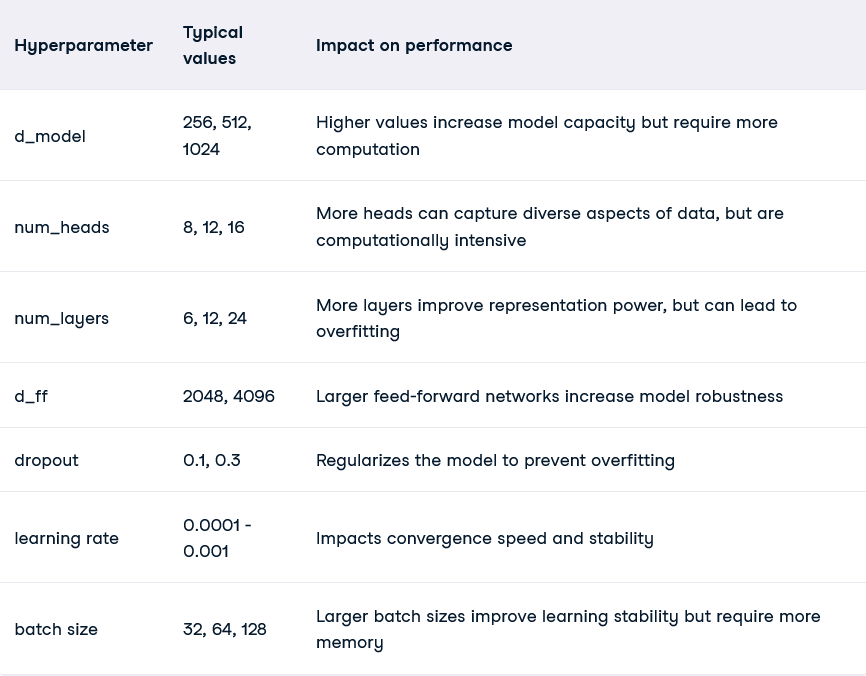

In [18]:
EMBED_DIM = 512
FF_DIM    = 2048
NUM_LAYERS = 6
NUM_HEADS  = 8
MAX_LEN    = 256
PAD_IDX = 0
EPOCHS = 5
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#  Деление на трейн вал и тест

In [19]:
train_data, temp_data = train_test_split(df_processed, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = MyDataset(train_data)
val_dataset   = MyDataset(val_data)
test_dataset  = MyDataset(test_data)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

# Создаем класс модели трансформер-суммаризатор


1.   Слои включают энкодер, создающий векторное контекстное представление, которое затем использует декодер. Выходной слой преобразует вектор декодера в вероятностное распределение по всему словарю
2.   Позиционные кодировки. Так как трансформер, в отличие от рекуррентных НС, не запоминает позицию, нам нужно закодировать позицию токенов, чтобы модель ее запоминала
3. Прямой проход




In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(1, max_len, d_model)
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return self.dropout(x)

class TransformerSummarizer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, pad_idx, max_len):
        """
        Transformer-based summarization model.

        Args:
            vocab_size: Size of vocabulary
            embed_dim: Embedding dimension
            num_heads: Number of attention heads
            ff_dim: Feed-forward dimension
            num_layers: Number of transformer layers
            pad_idx: Padding token index
        """
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_enc = PositionalEncoding(
            d_model=embed_dim,
            max_len=max_len,
            dropout=0.1
        )
        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=0.1,
            batch_first=True
        )
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.pad_idx = pad_idx
        self.vocab_size = vocab_size

    def forward(self, src, tgt, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        """
        Forward pass for training.

        Args:
            src: [batch_size, src_seq_len]
            tgt: [batch_size, tgt_seq_len]
            tgt_mask: Optional target mask
            src_key_padding_mask: Source padding mask
            tgt_key_padding_mask: Target padding mask

        Returns:
            Output logits [batch_size, tgt_seq_len, vocab_size]
        """
        self._validate_inputs(src, tgt)

        src_emb = self.pos_enc(self.embed(src))
        tgt_emb = self.pos_enc(self.embed(tgt))

        output = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        return self.fc_out(output)

    def generate(self, src, bos_idx=1, eos_idx=2, max_length=50, repetition_penalty=1.2):
        """
        Generate summary autoregressively with a repetition penalty.

        Args:
            src: (batch_size, src_seq_len) input token IDs
            max_length: Maximum length of the generated summary
            repetition_penalty: >1.0 penalizes tokens already generated

        Returns:
            Tensor of shape (batch_size, gen_len) with generated IDs
        """
        self._validate_inputs(src)

        device = src.device
        batch_size = src.size(0)

        src_emb = self.pos_enc(self.embed(src))
        src_padding_mask = (src == self.pad_idx)

        tgt = torch.full((batch_size, 1), bos_idx, dtype=torch.long, device=device)

        for _step in range(max_length - 1):
            tgt_emb = self.pos_enc(self.embed(tgt))
            tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(device)
            tgt_padding_mask = (tgt == self.pad_idx)

            out = self.transformer(
                src_emb,
                tgt_emb,
                tgt_mask=tgt_mask,
                src_key_padding_mask=src_padding_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )

            logits = self.fc_out(out[:, -1, :])

            # Apply repetition penalty: for each batch item, any token that’s
            # already in tgt[i] will have its logit divided by penalty
            for i in range(batch_size):
                generated = tgt[i].tolist()
                if repetition_penalty != 1.0:
                    # convert to set to penalize each token only once
                    for token_id in set(generated):
                        logits[i, token_id] = logits[i, token_id] / repetition_penalty

            next_token = logits.argmax(dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)

            if (next_token == eos_idx).all():
                break

        return tgt


    def _validate_inputs(self, src, tgt=None):
        """Validate input tensors for device and indices"""
        assert src.device == self.embed.weight.device, \
               f"Input device {src.device} != model device {self.embed.weight.device}"

        assert src.min() >= 0 and src.max() < self.vocab_size, \
               f"Source tokens out of range [0, {self.vocab_size-1}]"

        if tgt is not None:
            assert tgt.device == src.device, "Source and target devices must match"
            assert tgt.min() >= 0 and tgt.max() < self.vocab_size, \
                   f"Target tokens out of range [0, {self.vocab_size-1}]"

def generate_square_subsequent_mask(sz):
    """Generate causal mask for autoregressive decoding"""
    return torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)

In [23]:
VOCAB_SIZE = sp.get_piece_size()

In [24]:
PAD_IDX = sp.pad_id()

# Функция обучения модели

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, epochs, vocab_size, pad_idx):
    """
    Training loop for the TransformerSummarizer model.

    Args:
        model: TransformerSummarizer model instance.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function (e.g., nn.CrossEntropyLoss).
        optimizer: Optimizer (e.g., AdamW).
        scheduler: Learning rate scheduler.
        scaler: GradScaler for mixed precision training.
        device: Device to run the model on (e.g., 'cuda').
        epochs: Number of training epochs.
        vocab_size: Size of the vocabulary (e.g., 30522).
        pad_idx: Index of the padding token (e.g., 0).

    Returns:
        None (prints training and validation metrics).
    """
    train_losses = []
    val_losses = []
    epoch_loss = 0.0
    total_tokens = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        total_tokens = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for src, tgt in pbar:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()

            tgt_input = tgt[:, :-1]
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

            src_padding_mask = (src == pad_idx).to(device)
            tgt_padding_mask = (tgt_input == pad_idx).to(device)

            with autocast('cuda', dtype=torch.float16):
                output = model(
                    src,
                    tgt_input,
                    tgt_mask=tgt_mask,
                    src_key_padding_mask=src_padding_mask,
                    tgt_key_padding_mask=tgt_padding_mask
                )
                loss = criterion(
                    output.contiguous().view(-1, vocab_size),
                    tgt[:, 1:].contiguous().view(-1)
                )
                non_pad_positions = (tgt[:, 1:] != pad_idx).sum().item()
                epoch_loss += loss.item() * non_pad_positions
                total_tokens += non_pad_positions

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            pbar.set_postfix(token_loss=f"{loss.item():.4f}")


        avg_train_loss = epoch_loss / total_tokens
        train_losses.append(avg_train_loss)
        print(f"\nEpoch {epoch+1} average training Loss: {avg_train_loss:.4f}")

        # Валидация
        model.eval()
        val_loss = 0
        val_tokens = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input = tgt[:, :-1]
                tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                src_padding_mask = (src == pad_idx).to(device)
                tgt_padding_mask = (tgt_input == pad_idx).to(device)

                with autocast(device_type='cuda', dtype=torch.float16):
                    output = model(
                        src,
                        tgt_input,
                        tgt_mask=tgt_mask,
                        src_key_padding_mask=src_padding_mask,
                        tgt_key_padding_mask=tgt_padding_mask
                    )
                    loss = criterion(
                        output.contiguous().view(-1, vocab_size),
                        tgt[:, 1:].contiguous().view(-1)
                    )
                    non_pad_positions = (tgt[:, 1:] != pad_idx).sum().item()

                val_loss += loss.item() * non_pad_positions
                val_tokens += non_pad_positions

            avg_val_loss = val_loss / val_tokens
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1} average validation Loss: {avg_val_loss:.4f}")

        # Сохраняем чекпоинт модели
        torch.save(model.state_dict(), f"transformer_summarizer_epoch_{epoch+1}.pt")

    return train_losses, val_losses

In [26]:
model = TransformerSummarizer(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS, PAD_IDX, MAX_LEN).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, reduction='mean')

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.05 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

scaler = GradScaler()

# Начинаем обучение модели, сохраняем функцию потерь в списки для дальнейшей визуализации

In [27]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, DEVICE, EPOCHS, VOCAB_SIZE, PAD_IDX
)

Epoch 1/5: 100%|██████████| 4018/4018 [22:55<00:00,  2.92it/s, token_loss=5.0403]


Epoch 1 average training Loss: 5.6669


Epoch 1 average validation Loss: 4.8221


Epoch 2/5: 100%|██████████| 4018/4018 [22:58<00:00,  2.92it/s, token_loss=4.4045]


Epoch 2 average training Loss: 4.6658


Epoch 2 average validation Loss: 4.4358


Epoch 3/5: 100%|██████████| 4018/4018 [22:56<00:00,  2.92it/s, token_loss=4.2006]


Epoch 3 average training Loss: 4.3630


Epoch 3 average validation Loss: 4.2438


Epoch 4/5: 100%|██████████| 4018/4018 [22:57<00:00,  2.92it/s, token_loss=3.8353]


Epoch 4 average training Loss: 4.1871


Epoch 4 average validation Loss: 4.1410


Epoch 5/5: 100%|██████████| 4018/4018 [22:56<00:00,  2.92it/s, token_loss=3.8334]


Epoch 5 average training Loss: 4.0839


Epoch 5 average validation Loss: 4.0993


# Код для загрузки модели в формате .pt и проверки генерации саммари

In [ ]:
# выполнять только если загружаешь модель, если ты только обучил, тогда в переменной уже сидит нужная модель
model = TransformerSummarizer(VOCAB_SIZE, EMBED_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS, PAD_IDX, MAX_LEN).to(DEVICE)
state_dict = torch.load("/content/transformer_summarizer_epoch_5.pt", map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
input_texts = pd.read_csv(path + '/wikihowAll.csv')

In [ ]:
print(input_texts['text'][3])
print('_____________')
print(input_texts['headline'][3])

In [ ]:
input_text = df['text'][2414]
target_sum = df['headline'][2414]

encoded = safe_encode(input_text)
src_tensor = torch.tensor(encoded, dtype=torch.long, device=DEVICE).unsqueeze(0)
src_tensor = src_tensor[:, :MAX_LEN]

model.eval()
with torch.no_grad():
    output_ids = model.generate(src_tensor, max_length=256)

gen_ids = output_ids[0].cpu().tolist()

summary = sp.decode_ids(gen_ids)
print("Generated summary:", summary)
print("Target summary:", target_sum)
print("Original text: ", input_text)


Generated summary: Look for signs of infection., Check the label., Notice if your cat is too long.
Target summary: 
Check the length of the cockatiels nails.,
Have the nails trimmed by a vet or trained professional.,
Get a friend to hold the bird steady for you.,
Look for the quick.,
Clip carefully.
Original text:   Generally, the nails are too long if the toe is unable to make full contact with the ground when the cockatiel is placed on a flat surface.Another way to evaluate whether the nails are too long is to pay attention to the feeling of the birds nails when they perch on your hand or arm. If the nails are so sharp that they cut, scratch, or cause pain in your arm, its time to get them trimmed., Before doing it yourself, it will help to see a pet shop employee or veterinarian trim your cockatiels nails. This way, youll know how to properly trim them when you try it yourself.Even if you cant be present to see hem actually do it, it will help to observe the length of the nails befo

**Generated summary:** Learn the basics of a song., Understand that you can't be able to read your music., Know what to do with your favorite songs. , Choose a style for your video., Decide on a theme., Pick a song or song that is best for you., Select a song that fits your video., Start writing your video., Play it up and enjoy!

**Target summary:** Practice your material until you can perform each song perfectly., Choose whether you're going to record your music in your own home studio or a professional recording studio., Prove your talent., Pick your best three to five songs for a demo submission., Write a brief bio., Visit http://www.PhantomCityStudio.com/Demos for up-to-date information on how to properly submit your music demo. , Complete the demo submission process. , Wait a for a response.


**Generated summary:** Decide what you want to do., Choose a topic that is right for you., Write your resume., Create an outline of the job., Make sure you have enough space in writing., Start with a list of all the necessary materials., Keep it simple and concise.

**Target summary:** Introduce yourself., Talk about why you like them so much., Say thank you., Keep your letter short., Use neat handwriting., Decorate your letter or envelope., Ask for an autograph., Talk to an adult.

## Оцениваем модель на тестовой выборке

In [30]:
pip install bert_score -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 635.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [54]:
# кусочек тестовой выборки - а то оценка идет очень долго

test_data = test_data.sample(frac=0.1, random_state=42)

test_dataset  = MyDataset(test_data)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

In [37]:
from bert_score import score as bert_score

def calculate_bertscore(model, loader, sp, max_len=MAX_LEN, lang='ru', device='cuda'):
    """
    Вычисляет BERTScore для модели на заданном DataLoader.

    Args:
        model: Модель суммаризации.
        loader: DataLoader с тестовыми/валидационными данными.
        sp: SentencePieceProcessor или объект токенизатора с методом decode_ids.
        max_len: Максимальная длина генерации.
        lang: Язык ('ru' для русского).
        device: Устройство ('cuda' или 'cpu').

    Returns:
        Словарь с precision, recall, F1 BERTScore.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for src, tgt in tqdm(loader, desc="Calculating BERTScore"):
            src, tgt = src.to(device), tgt.to(device)

            # Генерируем текст
            generated = model.generate(src, max_length=max_len)

            # Декодируем предсказания и цели
            preds = [sp.decode_ids(generated[i].cpu().tolist()) for i in range(len(generated))]
            targets = [sp.decode_ids(tgt[i].cpu().tolist()) for i in range(len(tgt))]

            all_preds.extend(preds)
            all_targets.extend(targets)

    # Вычисляем BERTScore
    P, R, F1 = bert_score(all_preds, all_targets, lang=lang, device=device)

    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }

In [55]:
#применяем бертскор
test_bertscore = calculate_bertscore(model, test_loader, sp)
print(f"Test BERTScore — Precision: {test_bertscore['bertscore_precision']:.4f}, Recall: {test_bertscore['bertscore_recall']:.4f}, F1: {test_bertscore['bertscore_f1']:.4f}")

Calculating BERTScore: 100%|██████████| 14/14 [14:21<00:00, 61.54s/it]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Test BERTScore — Precision: 0.6487, Recall: 0.7003, F1: 0.6728


BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. It has been shown to correlate with human judgment on sentence-level and system-level evaluation. Moreover, BERTScore computes precision, recall, and F1 measure, which can be useful for evaluating different language generation tasks.

In [41]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0632a81e52884e6079262174d946ef9059059ca7d675fdae93cf45b7188b5424
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [45]:
# Загружаем метрику ROUGE
rouge_metric = evaluate.load('rouge')

def evaluate_with_rouge(model, test_loader, sp_model=sp, device='cuda'):
    """
    Оценивает модель суммаризации с использованием метрики ROUGE.

    Args:
        model: обученная модель суммаризации
        test_loader: DataLoader с тестовыми данными (src, tgt)
        sp_model: SentencePiece-токенизатор
        device: 'cuda' или 'cpu'

    Returns:
        dict: {'rouge1', 'rouge2', 'rougeL', 'rougeLsum'}
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for src, tgt in tqdm(test_loader, desc="Evaluating"):
            src = src.to(device)
            tgt = tgt.to(device)

            # Генерация выходных последовательностей
            generated = model.generate(src)

            # Декодируем каждую последовательность в текст
            for i in range(generated.shape[0]):
                pred_ids = generated[i].cpu().tolist()
                target_ids = tgt[i].cpu().tolist()

                pred_text = sp_model.decode_ids(pred_ids)
                target_text = sp_model.decode_ids(target_ids)

                all_preds.append(pred_text)
                all_targets.append(target_text)

    # Вычисляем метрики
    results = rouge_metric.compute(predictions=all_preds, references=all_targets)
    return {
        'rouge1': results['rouge1'],
        'rouge2': results['rouge2'],
        'rougeL': results['rougeL'],
        'rougeLsum': results['rougeLsum']
    }

In [48]:
#применяем руж
test_scores = evaluate_with_rouge(model, test_loader)
print(f"Test ROUGE Scores — Rouge-1: {test_scores['rouge1']:.4f}, Rouge-2: {test_scores['rouge2']:.4f}, Rouge-L: {test_scores['rougeL']:.4f}")

Evaluating: 100%|██████████| 134/134 [14:58<00:00,  6.70s/it]


Test ROUGE Scores — Rouge-1: 0.2124, Rouge-2: 0.0308, Rouge-L: 0.1404


ROUGE, or Recall-Oriented Understudy for Gisting Evaluation,[1] is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. ROUGE metrics range between 0 and 1, with higher scores indicating higher similarity between the automatically produced summary and the reference.

# Визуализации

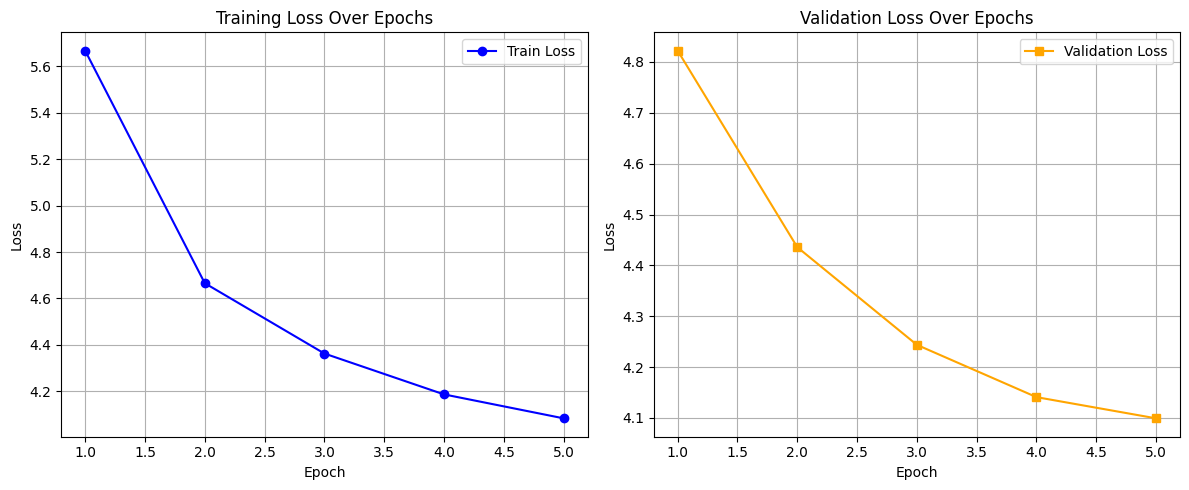

In [29]:
import matplotlib.pyplot as plt

# === График 1: Потери на обучающей выборке ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', color='blue', label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# === График 2: Потери на валидационной выборке ===
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_losses, marker='s', color='orange', label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-53-a733ceb4625e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='Metric', y='Score', data=df, palette='Blues_d')


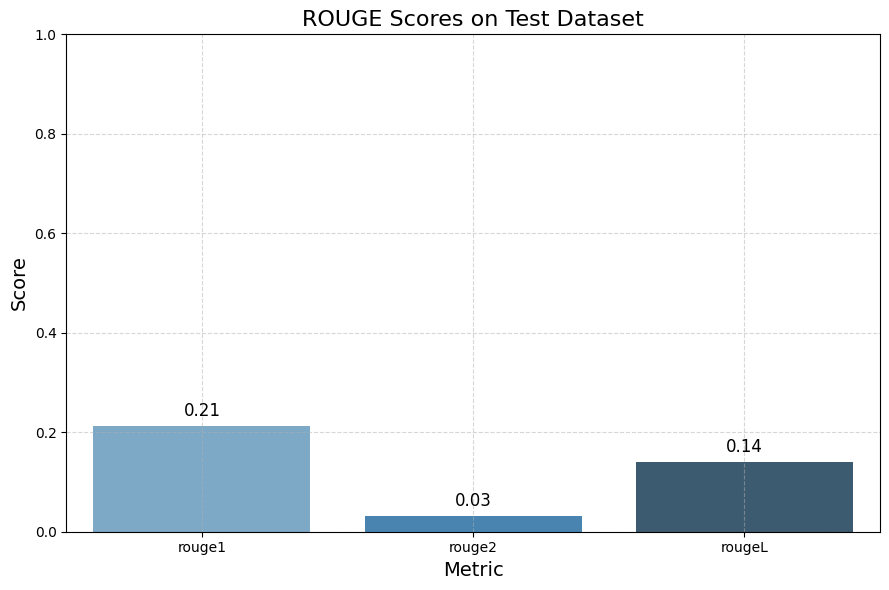

In [53]:
# График руж скоров на тестовой выборке

import seaborn as sns

# Формируем DataFrame
plot_metrics = {k: v for k, v in test_scores.items() if k != 'rougeLsum'}
df = pd.DataFrame({
    'Metric': list(plot_metrics.keys()),
    'Score': list(plot_metrics.values())
})

# Строим график
plt.figure(figsize=(9, 6))
bar = sns.barplot(x='Metric', y='Score', data=df, palette='Blues_d')

# Добавляем заголовок и подписи
plt.title('ROUGE Scores on Test Dataset', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)

# Подписываем значения над столбцами
for index, row in df.iterrows():
    bar.text(row.name, row['Score'] + 0.02, f'{row["Score"]:.2f}',
             color='black', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-56-453ba4c06389>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='Metric', y='Score', data=df_bert, palette='coolwarm')


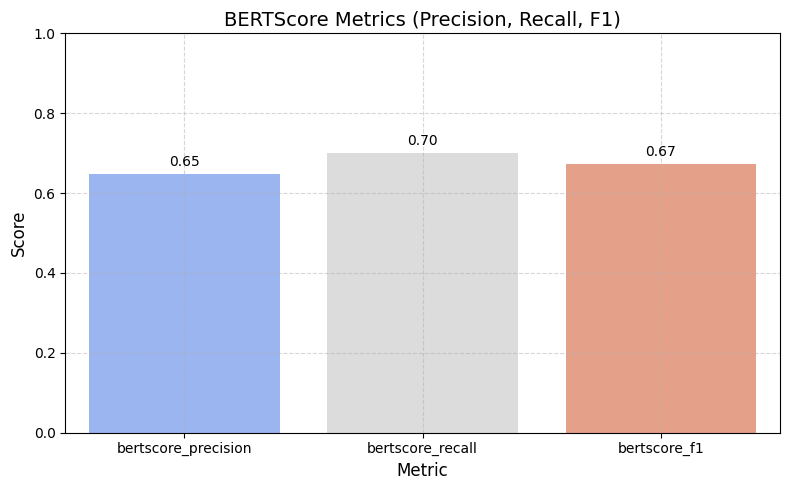

In [56]:
# бертскор на тестовой выборке
df_bert = pd.DataFrame({
    'Metric': list(test_bertscore.keys()),
    'Score': list(test_bertscore.values())
})

# Строим график
plt.figure(figsize=(8, 5))
bar = sns.barplot(x='Metric', y='Score', data=df_bert, palette='coolwarm')

# Настройки графика
plt.title('BERTScore Metrics (Precision, Recall, F1)', fontsize=14)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)

# Подписываем значения над столбцами
for index, row in df_bert.iterrows():
    bar.text(row.name, row['Score'] + 0.02, f'{row["Score"]:.2f}',
             color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Итоговые мысли


*   Обучение модели с нуля - нетривиальная задачка без хороших гпушек...
*   При наличии времени (привет, сеанс в колабе) в целом можно сделать что-то удобоваримое, особенно при использовании проверенных стратегий обучения
*   Вайб-кодинг - норм, но только для ручных задач, которые легко можно сделать самому (пока, матплотлиб). Для более сложных типа токенизации датасета (от чего зависит большая часть результата) или определения слоев модели не надо...

